In [22]:
fit_names = [f"NNPDF40_nnlo_as_0{n}_corr_s{l}" for l in "12" for n in [1140,1150,1160,1170,1175,1180,1185,1190,1195,1200,1210,1220]]

# fit_names = [f"220221-ern-00{n}{l}" for l in "ab" for n in range(1,10)]
# fit_names = [f"230220-rs-00{n}{l}" for l in "ab" for n in range(1,10)]

# fit_names = ["230131-rs-nnpdf40-corr-01140-a", "230131-rs-nnpdf40-corr-01140-b", "230131-rs-nnpdf40-corr-01150-a", "230131-rs-nnpdf40-corr-01150-b", "230131-rs-nnpdf40-corr-01160-a", "230131-rs-nnpdf40-corr-01160-b", "230131-rs-nnpdf40-corr-01170-a", "230131-rs-nnpdf40-corr-01170-b", "230131-rs-nnpdf40-corr-01175-a", "230131-rs-nnpdf40-corr-01175-b", "230131-rs-nnpdf40-corr-01180-a", "230131-rs-nnpdf40-corr-01180-b", "230131-rs-nnpdf40-corr-01185-a", "230131-rs-nnpdf40-corr-01185-b", "230131-rs-nnpdf40-corr-01190-a", "230131-rs-nnpdf40-corr-01190-b", "230131-rs-nnpdf40-corr-01195-a", "230131-rs-nnpdf40-corr-01195-b", "230131-rs-nnpdf40-corr-01200-a", "230131-rs-nnpdf40-corr-01200-b", "230131-rs-nnpdf40-corr-01210-a", "230131-rs-nnpdf40-corr-01210-b", "230131-rs-nnpdf40-corr-01220-a", "230131-rs-nnpdf40-corr-01220-b", ]

In [23]:
from validphys.loader import FallbackLoader as Loader

In [24]:
from validphys.api import API

In [25]:
l = Loader()

In [26]:
fits = [l.check_fit(f) for f in fit_names]

In [27]:
def measure(replica_data):
    return replica_data.training*3 + replica_data.validation*1

In [28]:
from collections import defaultdict
as_fits = defaultdict(list)
for f in fits:
    th = f.as_input()["theory"]["theoryid"]
    alpha = float(API.theory_info_table(theory_db_id = th).loc["alphas"])
    as_fits[alpha].append(f)
as_fits = dict(as_fits)



In [29]:
indexes = {f: API.fitted_replica_indexes(pdf=f.name) for f in fits}

In [30]:
replica_data = {f: API.replica_data(fit=f.name) for f in fits}

In [31]:
import pandas as pd
import numpy as np

In [32]:
min_values = {}

for alpha, flist in as_fits.items():
    series = []
    for f in flist:
        s = [measure(d) for d in replica_data[f]]
        series.append(pd.Series(s, index=indexes[f]))
    min_values[alpha] = pd.DataFrame(series).min()

data = pd.DataFrame(min_values)


In [33]:
mins = {}
for ind, row in data.iterrows():
    a, b, c = np.polyfit(data.columns, row, 2)
    if not np.isnan(b):
        mins[ind] = -b / 2 / a
    # mins[ind] = data.columns[np.where(row==row.min())][0]

mins = pd.Series(mins)

In [34]:
f" {mins.mean():.5f} ± {mins.std():.5f} "

' 0.12170 ± 0.00080 '

In [35]:
mins.describe()

count    159.000000
mean       0.121697
std        0.000797
min        0.120274
25%        0.121140
50%        0.121539
75%        0.122205
max        0.125913
dtype: float64

In [36]:
# mins_std = mins.to_numpy().std()
# mins_mean = mins.to_numpy().mean()
# mins = np.array([i for i in mins if i < mins_mean+0.3*mins_std and i > mins_mean-0.3*mins_std])


In [37]:
f" {mins.mean():.5f} ± {mins.std():.5f} "

' 0.12170 ± 0.00080 '

In [39]:
from validphys.plotutils import kde_plot

In [40]:
kde_plot(mins)

<Axes: >

In [41]:
import matplotlib.pyplot as plt

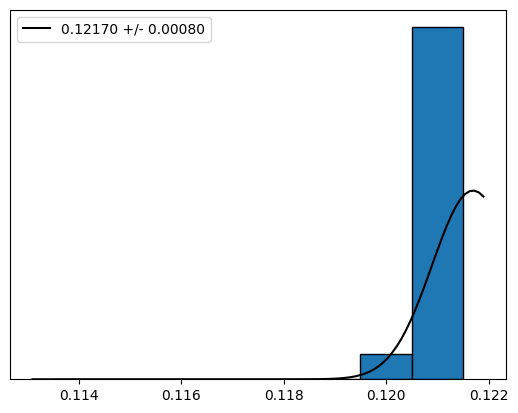

In [42]:
plt.hist(mins,bins=data.columns-0.0005,edgecolor='black',density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
from scipy.stats import norm
# p = np.exp(-((x-mins.mean())/mins.std())**2/2)*mins.size/np.sqrt(2*np.pi)
p = norm.pdf(x, mins.mean(), mins.std())
plt.plot(x,p,'k',label=f"{mins.mean():.5f} +/- {mins.std():.5f}")
plt.yticks([])
plt.legend()
plt.savefig('alphashist.pdf')

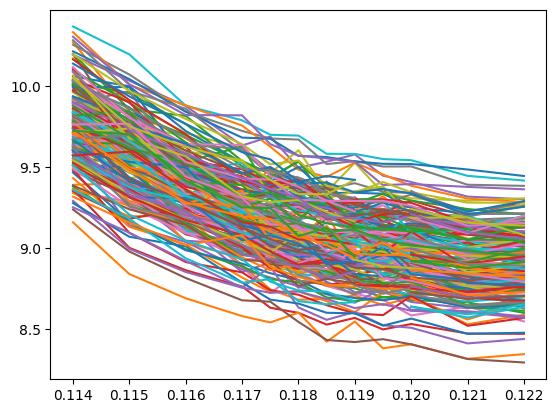

In [43]:
plt.plot(data.columns, np.array(data.T))